In [1]:
# IMPORTS
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper
import matplotlib.pyplot as plt
import random
from collections import deque
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import datetime
from keras.optimizers import Adam

In [2]:
# ─── Hyper-paramètres et environnement ────────────────────────────────────────
env_name = "MiniGrid-Empty-8x8-v0"
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.97
gamma = 0.99
batch_size= 32
memory_size = 50_000
episodes = 100
target_update_freq = 10

best_model_path = "best_q_model_cnn.weights.h5"

# Création de l'env avec observation image
env = ImgObsWrapper(gym.make(env_name))
state_shape  = env.observation_space.shape  # (7, 7, 3)
action_shape = env.action_space.n

In [3]:
# ─── Création du Q-network CNN ────────────────────────────────────────────────
def create_q_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=state_shape),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(action_shape, activation='linear'),
    ])
    model.compile(optimizer=Adam(learning_rate=0.003), loss='mse')
    return model

q_model      = create_q_model()
target_model = create_q_model()
target_model.set_weights(q_model.get_weights())

memory = deque(maxlen=memory_size)
def store_transition(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))
def sample_batch():
    batch = random.sample(memory, batch_size)
    state, action, reward, next_state, done = map(np.asarray, zip(*batch))
    return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)


c:\Users\Eddyj\Desktop\Github\mini_grid\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# ─── TensorBoard, callbacks, etc ──────────────────────────────────────────────
log_dir = "logs/minigrid_cnn/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.7, patience=10, min_lr=0.00001)
early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=best_model_path, monitor='loss', save_best_only=True, save_weights_only=True)


In [5]:
# ─── Politique epsilon-greedy ────────────────────────────────────────────────
def epsilon_greedy_policy(state, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(action_shape)
    q_values = q_model.predict(state[np.newaxis], verbose=0)[0]
    return np.argmax(q_values)

In [6]:
# ─── Une étape d'entraînement ────────────────────────────────────────────────
def train_step():
    if len(memory) < batch_size:
        return
    state, action, reward, next_state, done = sample_batch()

    next_q_values = target_model.predict(next_state, verbose=0)
    max_next_q_values = np.max(next_q_values, axis=1)

    target_q_values = q_model.predict(state, verbose=0)
    for i, a in enumerate(action):
        target_q_values[i][a] = reward[i] if done[i] else reward[i] + gamma * max_next_q_values[i]

    q_model.fit(state, target_q_values, verbose=0, callbacks=[tensorboard, reduce_lr, early_stop, checkpoint])


In [ ]:
# ─── Boucle d’entraînement ───────────────────────────────────────────────────
reward_history = []
success_history = []
loss_history = []
epsilon_history = []

for episode in range(1, episodes + 1):
    state, info = env.reset()
    episode_reward = 0
    done = False
    success = False
    step_count = 0

    while not done and step_count < 150:
        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        store_transition(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        step_count += 1

        if reward > 0:
            success = True
        train_step()
    # train_step()
        
    # epsilon decay
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    # sync target network
    if episode % target_update_freq == 0:
        target_model.set_weights(q_model.get_weights())

    reward_history.append(episode_reward)
    success_history.append(success)
    epsilon_history.append(epsilon)

    if episode % 10 == 0:
        avg_reward = np.mean(reward_history[-10:])
        success_rate = np.mean(success_history[-10:])
        print(f"Episode {episode:3d}/{episodes} — Avg Reward: {avg_reward:.2f} — Success Rate: {success_rate:.2f} — epsilon: {epsilon:.3f}")

    if success:
        if step_count <= 10:
            quality = "EXCELLENT"
        elif step_count <= 20:
            quality = "BON"
        else:
            quality = "NUL"
        print(f"Episode {episode} : VICTOIRE ({quality}) en {step_count} pas ! Reward : {episode_reward:.2f}")
    else:
        print(
            f"Episode {episode} — FAIL en {step_count} pas — Reward: {episode_reward:.2f} — epsilon: {epsilon:.3f}"
        )

Episode 1 — FAIL en 150 pas — Reward: 0.00 — epsilon: 0.970
Episode 2 — FAIL en 150 pas — Reward: 0.00 — epsilon: 0.941
Episode 3 — FAIL en 150 pas — Reward: 0.00 — epsilon: 0.913
Episode 4 — FAIL en 150 pas — Reward: 0.00 — epsilon: 0.885
Episode 5 — FAIL en 150 pas — Reward: 0.00 — epsilon: 0.859
Episode 6 — FAIL en 150 pas — Reward: 0.00 — epsilon: 0.833
Episode 7 — FAIL en 150 pas — Reward: 0.00 — epsilon: 0.808


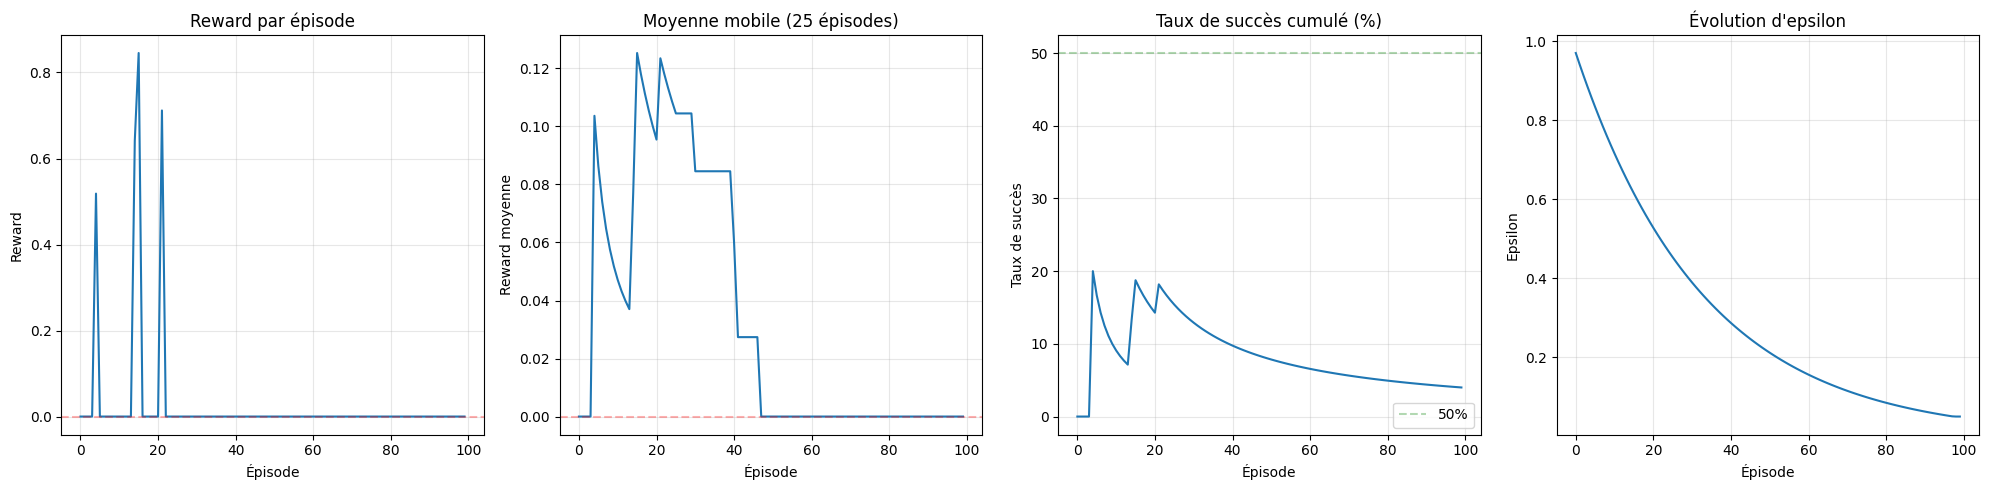

In [ ]:
# ─── Plots d'analyse ────────────────────────────────────────────
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.plot(reward_history)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.title('Reward par épisode')
plt.xlabel('Épisode')
plt.ylabel('Reward')
plt.grid(True, alpha=0.3)

plt.subplot(1, 4, 2)
window = 25
if len(reward_history) >= window:
    moving_avg = [np.mean(reward_history[max(0,i-window):i+1]) for i in range(len(reward_history))]
    plt.plot(moving_avg)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.title(f'Moyenne mobile ({window} épisodes)')
plt.xlabel('Épisode')
plt.ylabel('Reward moyenne')
plt.grid(True, alpha=0.3)

plt.subplot(1, 4, 3)
success_rate = np.cumsum(success_history) / np.arange(1, len(success_history)+1)
plt.plot(success_rate * 100)
plt.axhline(y=50, color='g', linestyle='--', alpha=0.3, label='50%')
plt.title('Taux de succès cumulé (%)')
plt.xlabel('Épisode')
plt.ylabel('Taux de succès')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 4, 4)
plt.plot(epsilon_history)
plt.title('Évolution d\'epsilon')
plt.xlabel('Épisode')
plt.ylabel('Epsilon')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ─── Évaluation/Exploitation du modèle ───────────────────────────────────────
state, info = env.reset()
done = False
total_reward = 0
success = False
step_count = 0

# Charger le meilleur modèle si dispo
if os.path.exists(best_model_path):
    q_model.load_weights(best_model_path)
    target_model.load_weights(best_model_path)

while not done and step_count < 100:
    action = np.argmax(q_model.predict(state[np.newaxis], verbose=0)[0])
    state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    step_count += 1
    if reward > 0:
        success = True
    env.render()

if success:
    if step_count <= 10:
        quality = "EXCELLENT"
    elif step_count <= 20:
        quality = "BON"
    else:
        quality = "NUL"
    print(f"Évaluation : VICTOIRE ({quality}) en {step_count} pas ! Reward : {total_reward:.2f}")
else:
    print(f"Évaluation : FAIL en {step_count} pas — Reward : {total_reward:.2f}")

c:\Users\Eddyj\Desktop\Github\mini_grid\.venv\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Évaluation : FAIL en 100 pas — Reward : 0.00
